

>## Konvolutivne Mreze

Arhitektura koja je dala najbolju preciznost, u fajlu Network_info su informacije o drugim arhitekturama koje nisu bile sjajne


In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
from torch import nn
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.patches import Patch

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# import os
# import zipfile

# zip_path = '/content/drive/MyDrive/Colab Notebooks/Fruits Vegetables.zip'
# extract_path = '/content/drive/MyDrive/Colab Notebooks/'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [9]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),

])

In [10]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/train', transform=transform)

In [11]:
test_dataset= ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/test' , transform=transform)

In [12]:
batch_size = 32
shuffle = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

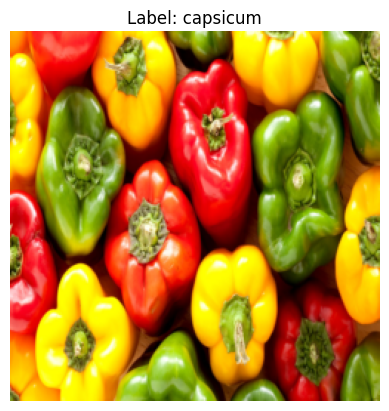

torch.Size([3, 250, 250])

In [ ]:
import matplotlib.pyplot as plt

img, label = train_dataset[500]
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(f'Label: {train_dataset.classes[label]}')
plt.axis('off')
plt.show()
img.shape

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 32, 3)
        self.layer2 = nn.Conv2d(32, 64, 3)
        self.layer3 = nn.Conv2d(64,128,3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(107648,36)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.pool(x)
        x = F.relu(self.layer2(x))
        x = self.pool(x)
        x = F.relu(self.layer3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [ ]:
model = ConvNet()

In [ ]:
from tqdm import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    with tqdm(dataloader, unit="batch") as tepoch:
        for X, y in tepoch:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = preds.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

            tepoch.set_postfix(loss=total_loss/(total+1e-10), accuracy=100.*correct/total)

    return total_loss / len(dataloader.dataset)


In [ ]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1:
                preds = outputs > 0
                num_same += sum(preds == y).item()
            else:
                _, indices = torch.max(outputs, 1)
                num_same += sum(indices == y).item()
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

In [ ]:
from torch import optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
num_epochs = 5
for epoch in range(num_epochs):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loop(test_loader, model, loss_fn, device)

  0%|          | 0/98 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 98/98 [12:17<00:00,  7.52s/batch, accuracy=9.53, loss=0.105]


Average loss: 0.08528143250510553
Accuracy: 0.3398328690807799


100%|██████████| 98/98 [11:42<00:00,  7.17s/batch, accuracy=26.9, loss=0.0817]


Average loss: 0.05998147530143971
Accuracy: 0.520891364902507


100%|██████████| 98/98 [11:48<00:00,  7.23s/batch, accuracy=41.2, loss=0.0645]


Average loss: 0.04261568861087384
Accuracy: 0.6824512534818942


100%|██████████| 98/98 [11:55<00:00,  7.30s/batch, accuracy=52.1, loss=0.0525]


Average loss: 0.029994216885075264
Accuracy: 0.7743732590529248


100%|██████████| 98/98 [12:10<00:00,  7.45s/batch, accuracy=61.2, loss=0.0411]


Average loss: 0.027351595565137093
Accuracy: 0.8189415041782729


In [21]:
val_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/validation', transform=transform)
val_dataLoader = DataLoader(val_dataset, batch_size=64, shuffle=False)
class_names = train_dataset.class_to_idx
print("Class Index - Class Name")
for idx, name in class_names.items():
    print(f"{idx} - {name}")

Class Index - Class Name
apple - 0
banana - 1
beetroot - 2
bell pepper - 3
cabbage - 4
capsicum - 5
carrot - 6
cauliflower - 7
chilli pepper - 8
corn - 9
cucumber - 10
eggplant - 11
garlic - 12
ginger - 13
grapes - 14
jalepeno - 15
kiwi - 16
lemon - 17
lettuce - 18
mango - 19
onion - 20
orange - 21
paprika - 22
pear - 23
peas - 24
pineapple - 25
pomegranate - 26
potato - 27
raddish - 28
soy beans - 29
spinach - 30
sweetcorn - 31
sweetpotato - 32
tomato - 33
turnip - 34
watermelon - 35


In [23]:
def show_images(images, labels, preds):
    plt.figure(figsize=(12, 6))
    for i in range(min(len(images), 8)):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'Predicted: {preds[i]}, Actual: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

all_labels = []
all_preds = []

In [ ]:
for images, labels in val_dataLoader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    labels_list = labels.cpu().numpy().tolist()
    preds_list = predicted.cpu().numpy().tolist()

    all_labels.extend(labels_list)
    all_preds.extend(preds_list)


    show_images(images.cpu(), labels_list, preds_list)


conf_matrix = confusion_matrix(np.array(all_labels), np.array(all_preds))


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




Output hidden; open in https://colab.research.google.com to view.


##ResNet

In [ ]:
import torchvision.models as models

In [ ]:
import torchvision.models as models
import torch.optim as optim


resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 131)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)


num_epochs = 5
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 3.5257681243273677
Epoch 2, Loss: 2.1133978026253835
Epoch 3, Loss: 1.5657222575070906
Epoch 4, Loss: 1.2765902749129705
Epoch 5, Loss: 1.1077213019740826
Accuracy: 87.1866295264624%


In [ ]:
resNet_labels=[]
resNet_preds=[]
resnet.eval()
with torch.no_grad():
    for images, labels in val_dataLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        labels_list = labels.cpu().numpy().tolist()
        preds_list = predicted.cpu().numpy().tolist()

        resNet_labels.extend(labels_list)
        resNet_preds.extend(preds_list)

        show_images(images.cpu(), labels_list, preds_list)

resNet_conf_matrix = confusion_matrix(np.array(resNet_labels), np.array(resNet_preds))


plt.figure(figsize=(10, 8))
sns.heatmap(resNet_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

##Vision Transformer

In [25]:
Vision_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
Vision_train_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/train', transform=Vision_transform)
Vision_test_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/test', transform=Vision_transform)
Vision_val_dataset = ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/validation', transform=Vision_transform)


Vision_train_loader = DataLoader(Vision_train_dataset, batch_size=32, shuffle=True)
Vision_test_loader = DataLoader(Vision_test_dataset, batch_size=32, shuffle=False)
Vision_val_dataLoader = DataLoader(Vision_val_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import sys
!{sys.executable} -m pip install timm
from timm import create_model


model = create_model('vit_base_patch16_224', pretrained=True)

for param in model.parameters():
    param.requires_grad = False



num_classes = 131
model.head = nn.Linear(model.head.in_features, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, labels in Vision_train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in Vision_test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Accuracy: {accuracy}%")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:

model.eval()
Vision_labels = []
Vision_preds = []
with torch.no_grad():
    for images, labels in Vision_val_dataLoader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        Vision_labels.extend(labels.cpu().numpy())
        Vision_preds.extend(predicted.cpu().numpy())


from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(np.array(Vision_labels), np.array(Vision_preds))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


##ResNet Implementation

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=131):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [5]:
def resnet18(num_classes=131):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

In [17]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),

])
batch_size = 8
shuffle = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
import torch.optim as optim


model = resnet18(num_classes=131)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Epoch 1, Loss: 3.4220001306289283
Epoch 2, Loss: 3.013750104720776
Epoch 3, Loss: 2.8325302882072254
Epoch 4, Loss: 2.7545571602307835
Epoch 5, Loss: 2.620168762329297
Accuracy: 35.65459610027855%


In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


resNet_labels = []
resNet_preds = []


model.eval()


with torch.no_grad():
    for images, labels in val_dataLoader:

        images, labels = images.to(device), labels.to(device)


        outputs = model(images)
        _, predicted = torch.max(outputs, 1)


        labels_list = labels.cpu().numpy().tolist()
        preds_list = predicted.cpu().numpy().tolist()


        resNet_labels.extend(labels_list)
        resNet_preds.extend(preds_list)


        show_images(images.cpu(), labels_list, preds_list)


resNet_conf_matrix = confusion_matrix(np.array(resNet_labels), np.array(resNet_preds))


plt.figure(figsize=(10, 8))
sns.heatmap(resNet_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Output hidden; open in https://colab.research.google.com to view.